# Notes

This notebook creates paper-ready plots of pipes traversing large scale structure, and also their points of closest approach to galaxies along the sightline.

It builds upon the work in Illustris_Zhang_Method/Paper_Plots_Pipe.ipynb and Illustris_Zhang_Method/Paper_Plots_Impact_Factor_Analysis.ipynb

It outputs plots to:

Raven:/u/cwalker/Illustris_Zhang_Method/Paper_Pipe_Plots_2/

# Imports

In [36]:
import os

import numpy as np
import illustris_python as il

from numpy import random as rand
from astropy import constants as c
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import binned_statistic_dd
from astropy.cosmology import Planck15 as cosmosource
import matplotlib.ticker as ticker

# Functions

In [2]:
def gadgetDens2SI(dens):
    """
    Original Artale function to convert TNG densities to SI units

    INPUTSRETURNS:

    dens : [values] densities from TNG

    RETURNS:

    dens converted to SI units
    """
    return dens*1E10*cel_Msol_si/cel_hubble/(cel_kpc_si/cel_hubble)**3

def TNG_Dens2SI(dens):
    """
    Like gadgetDens2SI but using astropy values for constants
    Strips result of units
    Developed in raven:/u/cwalker/Illustris_FRB_Project/yt-artale-constants.ipynb


    INPUTSRETURNS:

    dens : [values] densities from TNG

    RETURNS:

    dens converted to SI units
    """
    return dens*1E10*c.M_sun.to('kg').value/cosmosource.h/(c.kpc.to('m').value/cosmosource.h)**3

def TNG_Dens2SI_astropy(dens):
    """
    Like TNG_Dens2SI but does not strip result of units.
    Developed in raven:/u/cwalker/Illustris_FRB_Project/yt-artale-constants.ipynb


    INPUTSRETURNS:

    dens : [values] densities from TNG

    RETURNS:

    dens converted to SI units
    """

    return dens*1E10*c.M_sun.to('kg')/cosmosource.h/(c.kpc.to('m')/cosmosource.h)**3

   
    

# Begin

## Load and initialise data

In [3]:
# npipes      = 2  #number of pipes to create
snap_number = 99 #snapshot number for test


#number of pipes which were previously created for subhalo ID plotting
npipes_created = 5125

###################
#load general data#
###################

#simulation to use
sim_to_use_structureplot = 'TNG300-3' #the simulation which will be used for structure plotting
sim_to_use_subhaloIDplot = 'TNG300-1' #the simulation which will be used for subhalo plotting

#base path to simulations which will be used
basePath_structureplot = '/virgotng/universe/IllustrisTNG/{0}/output/'.format(sim_to_use_structureplot)
basePath_subhaloIDplot = '/virgotng/universe/IllustrisTNG/{0}/output/'.format(sim_to_use_subhaloIDplot)


#location of created pipe data
pipe_data_loc = '/ptmp/cwalker/Illustris_FRB_Project/Zhang_backups/pipes/{0}_WHIM_backup_new/'.format(sim_to_use_subhaloIDplot)

#location of created subhalo id list data
shID_lists_loc = '/u/cwalker/Illustris_Zhang_Method/SpeedTempTest/'

print('Loading Simulation: {0}'.format(sim_to_use_structureplot))
#gas, i.e. partType0 data to load
dataPT0 = il.snapshot.loadSubset(basePath_structureplot, snap_number, 'gas', fields=['Density',
                                                                       'ElectronAbundance',
                                                                       'StarFormationRate',
                                                                       'Coordinates',
                                                                       'Masses',
                                                                       'SubfindDMDensity'])


#load header
header = il.groupcat.loadHeader(basePath_structureplot,snap_number)

print(header)
print(dataPT0['Coordinates'].shape)
#print(dataPT4['Coordinates'].shape)



########################
#load subhalo plot data#
########################




    
#pipe data file name
pipe_data_file = 'Sim_{0}_Snap_{1}_dDMdz_Output_SpeedTempTest.npy'.format(sim_to_use_subhaloIDplot,snap_number)

#load pipe data
pipe_data = np.load(pipe_data_loc+pipe_data_file,allow_pickle=True).tolist()

#extract the particle IDs for each pipe
pipe_pIDs = pipe_data['LoSPartIDs']

#extract the bin coordinates for each pipe
pipe_bin_coords = pipe_data['LoSBinCoords']

#extract the true coordinates of each cell related to a bin on each pipe
pipe_cell_coords = pipe_data['LoSCellCoords']

#get the names of the subhalo ID list files for these pipes
shID_list_files = ['{0}/sim_{1}_snap_{2}_pipe_{3}_true_shID_list.npy'.format(shID_lists_loc,
                                                                             sim_to_use_subhaloIDplot,
                                                                             snap_number,
                                                                             i) for i in np.arange(npipes_created)]

#initialise array to hold the subhalo ID lists for these pipes
pipe_shIDs = []

#loop over the subhalo ID files, load the data
for j in range(len(shID_list_files)):

    #get the subhalo ID file path and name
    shID_file = shID_list_files[j]

    #load and append the data to array
    pipe_shIDs.append(np.load(shID_file))
        
        
        

Loading Simulation: TNG300-3
{'BoxSize': 205000.0, 'FlagDoubleprecision': 0, 'Git_commit': b'd203ec8b07c7e2bdda5f608aa0babea46d603699', 'Git_date': b'Thu Apr 7 14:14:27 2016 +0200', 'HubbleParam': 0.6774, 'Ngroups_ThisFile': 17040, 'Ngroups_Total': 377342, 'Nids_ThisFile': 9865718, 'Nids_Total': 160941491, 'Nsubgroups_ThisFile': 20702, 'Nsubgroups_Total': 391144, 'NumFiles': 16, 'Omega0': 0.3089, 'OmegaLambda': 0.6911, 'Redshift': 2.220446049250313e-16, 'Time': 0.9999999999999998}
(224519197, 3)


In [4]:
#checks

#for structure plots
print(dataPT0)
print(dataPT0['Coordinates'])
print(dataPT0['Density'].shape)
print(dataPT0['Coordinates'].shape)
print(header['Redshift'])
print(TNG_Dens2SI_astropy(dataPT0['Density']))
print(cosmosource.H(0))
print(c.c*1)
print((c.c*1)/(cosmosource.H(0)))

#for subhalo plots
print('number of pipes: {0},'.format(len(pipe_pIDs)), 'bins per pipe: {0}'.format(len(pipe_pIDs[0])))
print(len(pipe_shIDs), len(pipe_shIDs[0]))
print(len(pipe_cell_coords), len(pipe_cell_coords[0]))
print(len(pipe_bin_coords), len(pipe_bin_coords[0]))


{'count': 224519197, 'Density': array([1.6069147e-04, 1.6300871e-04, 1.6298045e-04, ..., 3.0414004e-08,
       1.6941138e-08, 1.1579136e-08], dtype=float32), 'ElectronAbundance': array([1.1595033, 1.1594934, 1.159428 , ..., 1.1562226, 1.1578196,
       1.1577954], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'Coordinates': array([[ 41996.45044221,  49570.44953853, 147638.50130911],
       [ 41996.50049303,  49573.92164461, 147634.02714711],
       [ 41989.9287013 ,  49571.77982588, 147633.6661432 ],
       ...,
       [ 29404.04257135,  17834.28028675,  95143.89047956],
       [ 28366.23146747,  13453.4463888 ,  94469.11923342],
       [123799.0701614 ,  75210.01235774,  35557.57070314]]), 'Masses': array([0.0462881 , 0.0416572 , 0.04924524, ..., 0.05737552, 0.04836568,
       0.06835926], dtype=float32), 'SubfindDMDensity': array([5.6729661e-03, 5.0898795e-03, 5.9910440e-03, ..., 9.8882303e-08,
       1.5041105e-07, 2.5409273e-08], dtype=fl

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


[4.99042482e-23 5.06238893e-23 5.06151080e-23 ... 9.44535461e-27
 5.26122943e-27 3.59600939e-27] kg / m3
67.74 km / (Mpc s)
299792458.0 m / s
4425634.16002362 m Mpc / km
number of pipes: 5125, bins per pipe: 10000
5125 10000
5125 10000
5125 10000


# Plot all subhalos for a randomised pipe




In [5]:
#initialise arrays to hold minimum distances from sightlines to subhalos impact factors
sh_minDists = [] #unique non- -1 subhalos
gal_minDists = [] #galaxies
wrg_minDists = [] #well-resolved galaxies

#get random pipe number for plotting
pipe_number = np.random.randint(0,5125)
print('Plotting pipe number: {0}'.format(pipe_number))

#loop over pipes
for i in range(npipes_created):
    
    if i == pipe_number: #check only first pipe to begin
        
        #load the data for this pipe
        bin_coords = pipe_bin_coords[i] #coordinates of bins along the line of sight
        cell_coords = pipe_cell_coords[i] #coordinaates of cells associated with these bins
        pIDs = pipe_pIDs[i] #particle IDs associated with these cells
        shIDs = pipe_shIDs[i] #subhalo IDs associated with these cells
        
        #get unique subhalos traversed by this pipe
        uq_shIDs = np.unique(shIDs)
        
        #select unique subhalos which are not -1
        uq_shIDs = [shID for shID in uq_shIDs if shID!=-1]
        
        #get the coordinates of minimum distance to these subhalos.
        #this is where the los coordinate's (i.e. the bin coordinate's) x component
        #is equal to the subhalo center's x coordinate. y and z will always be the same
        #for the sightline.
        
        #initialise arrays
        minDist_coords = [] #array to hold coordinates of minimum distance to the subhalos
        minDists = [] #array to hold the minimum distances to the subhalos
        
        #loop over subhalos
        for j in range(len(uq_shIDs)):
            
            #get subhalo ID
            shID = uq_shIDs[j]
            
            #load the subhalo data
            sh_data = il.groupcat.loadSingle(basePath_subhaloIDplot, snap_number, subhaloID=shID)
            
            #get the central position of the subhalo [code units = ckpc/h]
            sh_centpos = sh_data['SubhaloPos']
            print('Central position of subhalo {0}: {1}'.format(shID,sh_centpos))
            
            #get the coordinates of minimum distance [code units = ckpc/h]
            minDist_xyz = [sh_centpos[0],bin_coords[0][1],bin_coords[0][2]]
            print('coordinates of minimum distance: {0}'.format(minDist_xyz))
            
            #get the coordinates of gas cells associated with the subhalo
            sh_gas_coords = il.snapshot.loadSubhalo(basePath_subhaloIDplot, snap_number, shID, 'gas', fields=None)['Coordinates']
            #print('Gas coordinates of this subhalo: {0}'.format(sh_gas_coords))
            
            #plot the subhalo data
            fig = plt.figure(figsize=(12,9))
            ax=fig.add_subplot(111,projection='3d')
            ax.scatter3D(sh_gas_coords[:,0],sh_gas_coords[:,1],sh_gas_coords[:,2],label='subhalo gas cells') #the subhalo
            ax.scatter3D(bin_coords[:,0],bin_coords[:,1],bin_coords[:,2],label = 'segment sightline') #the los
            ax.plot(list(zip(sh_centpos,minDist_xyz))[0],
                    list(zip(sh_centpos,minDist_xyz))[1],
                    list(zip(sh_centpos,minDist_xyz))[2],
                   color='r',lw=5,label='minimum approach') #the impact factor
            plt.legend()
            plt.show()

            #append to array
            minDist_coords.append(minDist_xyz)
            
            #calculate the minimum distance [code units = ckpc/h]
            minDist = np.sqrt(((minDist_xyz[0]-sh_centpos[0])**2) +\
                              ((minDist_xyz[1]-sh_centpos[1])**2) +\
                              ((minDist_xyz[2]-sh_centpos[2])**2))
            #append to array
            minDists.append(minDist)
         
        #get unique subhalos which are galaxies (i.e. stellar mass > 0)
        gal_shIDs = [shID for shID in uq_shIDs if\
                     il.groupcat.loadSingle(basePath_subhaloIDplot, snap_number, subhaloID=shID)['SubhaloMassType'][4]>0]
        
        #get unique subhalos which are well-resolved galaxies (i.e. containing >100 star particles)
        wrg_shIDs = [shID for shID in uq_shIDs if\
                     il.groupcat.loadSingle(basePath_subhaloIDplot, snap_number, subhaloID=shID)['SubhaloLenType'][4]>100]
        

        
        print('subhalos',uq_shIDs)
        print('galaxies',gal_shIDs)
        print('well-resolved',wrg_shIDs)
        print(minDist_coords)
        print('minimum distances: {0}'.format(minDists))

Plotting pipe number: 1155
subhalos []
galaxies []
well-resolved []
[]
minimum distances: []


# Plot a better version of a select pipe and subhalo

2697592.0
Central position of subhalo 2697592.0: [128815.85   80154.016 204121.03 ]
coordinates of minimum distance: [128815.85, 80139.2872482229, 204038.36584073046]


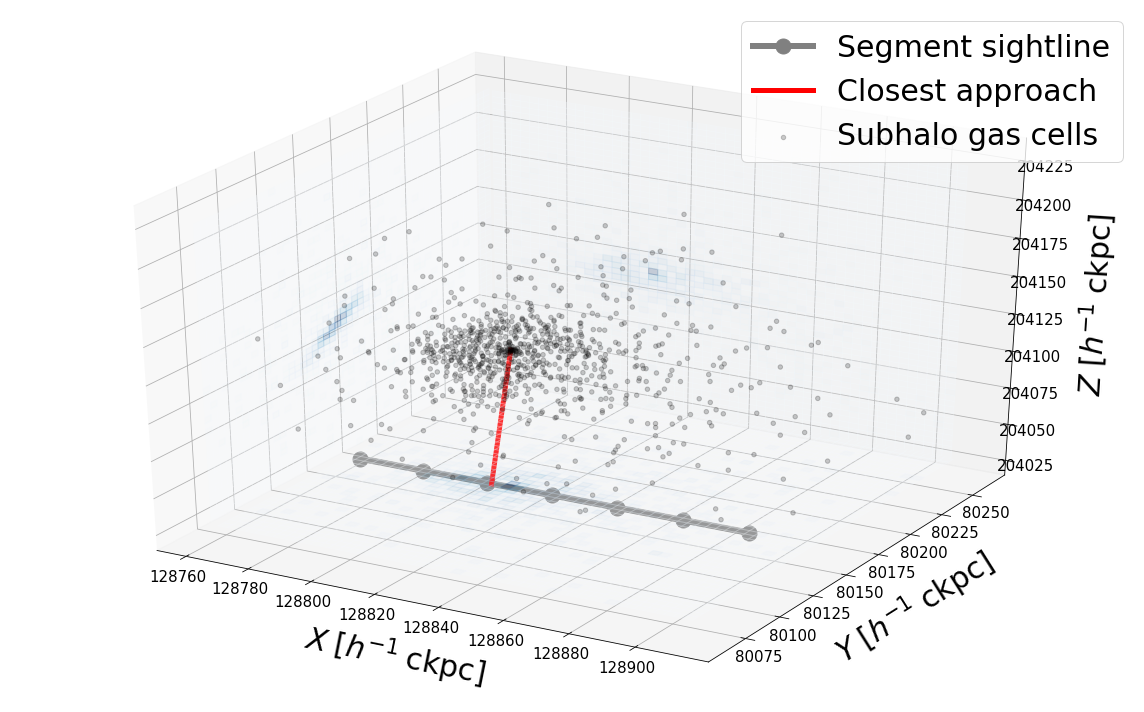

In [6]:
pipe_toplot = 297 #choose pipe to plot
subhalo_toplot = 2 #choose which subhalo in the pipe

bin_coords = pipe_bin_coords[pipe_toplot] #coordinates of bins along the line of sight
cell_coords = pipe_cell_coords[pipe_toplot] #coordinaates of cells associated with these bins
pIDs = pipe_pIDs[pipe_toplot] #particle IDs associated with these cells
shIDs = pipe_shIDs[pipe_toplot] #subhalo IDs associated with these cells

#get unique subhalos traversed by this pipe
uq_shIDs = np.unique(shIDs)

#select unique subhalos which are not -1
uq_shIDs = [shID for shID in uq_shIDs if shID!=-1]

#get the coordinates of minimum distance to these subhalos.
#this is where the los coordinate's (i.e. the bin coordinate's) x component
#is equal to the subhalo center's x coordinate. y and z will always be the same
#for the sightline.

#initialise arrays
minDist_coords = [] #array to hold coordinates of minimum distance to the subhalos
minDists = [] #array to hold the minimum distances to the subhalos

#choose which one to plot
shID = uq_shIDs[subhalo_toplot]
print(shID)

#load the subhalo data
sh_data = il.groupcat.loadSingle(basePath_subhaloIDplot, snap_number, subhaloID=shID)
#print(sh_data)

#get the central position of the subhalo [code units = ckpc/h]
sh_centpos = sh_data['SubhaloPos']
print('Central position of subhalo {0}: {1}'.format(shID,sh_centpos))

#get the coordinates of minimum distance [code units = ckpc/h]
minDist_xyz = [sh_centpos[0],bin_coords[0][1],bin_coords[0][2]]
print('coordinates of minimum distance: {0}'.format(minDist_xyz))

#get the coordinates of gas cells associated with the subhalo
sh_gas_coords = il.snapshot.loadSubhalo(basePath_subhaloIDplot, snap_number, shID, 'gas', fields=None)['Coordinates']
#print('Gas coordinates of this subhalo: {0}'.format(sh_gas_coords))

#plot the subhalo data
fig = plt.figure(figsize=(16,10))
#ax1=fig.add_subplot(121,projection='3d')


ax2=fig.add_subplot(111,projection='3d')
#ax2.set_xlim(0,header['BoxSize'])

ax2.set_xlabel(r'$X\;[h^{-1}\;{\rm ckpc}]$',fontsize=30,labelpad=25)
ax2.set_ylabel(r'$Y\;[h^{-1}\;{\rm ckpc}]$',fontsize=30,labelpad=25)
ax2.set_zlabel(r'$Z\;[h^{-1}\;{\rm ckpc}]$',fontsize=30,labelpad=25)

#ax2.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
ax2.tick_params(axis='both', which='major', labelsize=15)

ax2.scatter3D(sh_gas_coords[:,0],
              sh_gas_coords[:,1],
              sh_gas_coords[:,2],
              label='Subhalo gas cells',
              color='k',
              alpha=0.2) #the subhalo

#ax2.scatter3D(bin_coords[:,0],
#              bin_coords[:,1],
#              bin_coords[:,2],
#              color='gray',
#              lw=6,
#              label='Segment sightline',alpha=1) #the los


ax2.plot(bin_coords[:,0][np.where((bin_coords[:,0]>np.amin(sh_gas_coords[:,0])) & (bin_coords[:,0]<np.amax(sh_gas_coords[:,0])))],
              bin_coords[:,1][np.where((bin_coords[:,0]>np.amin(sh_gas_coords[:,0])) & (bin_coords[:,0]<np.amax(sh_gas_coords[:,0])))],
              bin_coords[:,2][np.where((bin_coords[:,0]>np.amin(sh_gas_coords[:,0])) & (bin_coords[:,0]<np.amax(sh_gas_coords[:,0])))],
              color='gray',
              lw=6,
              ls='-',
              marker='o',
              markersize=15,
              label='Segment sightline',alpha=1) #the los (but only zoomed in around the galaxy)

##PLOT PROJECTION OF ALL CELLS IN THE SUBHALO##

x = sh_gas_coords[:,0]
y = sh_gas_coords[:,1]
z = sh_gas_coords[:,2]

#ax2.set_xlim(np.amin(sh_gas_coords[:,0]),
#np.amax(sh_gas_coords[:,0]))

##

test_h, test_yedges, test_zedges = np.histogram2d(y, z, bins=50)
test_h = test_h.transpose()
test_normalized_map = plt.cm.Blues(test_h/test_h.max())

test_yy, test_zz = np.meshgrid(test_yedges, test_zedges)
test_xpos = min(x)-2 # Plane of histogram
test_xflat = np.full_like(test_yy, test_xpos) 

ax2.plot_surface(test_xflat, test_yy, test_zz, facecolors=test_normalized_map, alpha=0.2,rstride=1, cstride=1, shade=False,zorder=0)
##

test_h, test_xedges, test_zedges = np.histogram2d(x, z, bins=50)
test_h = test_h.transpose()
test_normalized_map = plt.cm.Blues(test_h/test_h.max())

test_xx, test_zz = np.meshgrid(test_xedges, test_zedges)
test_ypos = max(y)-2 # Plane of histogram
test_yflat = np.full_like(test_xx, test_ypos) 

ax2.plot_surface(test_xx, test_yflat, test_zz, facecolors=test_normalized_map, alpha=0.2,rstride=1, cstride=1, shade=False,zorder=0)


##

test_h, test_xedges, test_yedges = np.histogram2d(x, y, bins=50)
test_h = test_h.transpose()
test_normalized_map = plt.cm.Blues(test_h/test_h.max())

test_xx, test_yy = np.meshgrid(test_xedges, test_yedges)
test_zpos = min(z)-2 # Plane of histogram
test_zflat = np.full_like(test_xx, test_zpos) 

ax2.plot_surface(test_xx, test_yy, test_zflat, facecolors=test_normalized_map, alpha=0.2,rstride=1, cstride=1, shade=False,zorder=0)



ax2.plot(list(zip(sh_centpos,minDist_xyz))[0],
        list(zip(sh_centpos,minDist_xyz))[1],
        list(zip(sh_centpos,minDist_xyz))[2],
       color='r',lw=5,label='Closest approach') #the impact factor

ax2.legend(fontsize=30,loc=1)
plt.tight_layout()
plt.show()

# Plot both subhalo and structure

In [7]:
############
#initialise#
############

#The number of cells in the chosen snapshot
ncells = dataPT0['Coordinates'].shape[0]
print('Number of cells in snapshot {0} is {1}'.format(snap_number,ncells))

#The width of the pipe
pipe_width = 200 #By following zhang+20 definition, sides will be 200ckpc/h in length
print('Pipe width will be {0} ckpc/h'.format(pipe_width))

#The number of bins along a single line of sight
nbins=10000 #Zhang+20 definition: 10,000
print('There will be {0} bins on each sightline'.format(nbins))

#Define the mass of a proton for dDM/dz calculations
protonmass = c.m_p.to('kg')
print('Proton mass is {0}'.format(protonmass))

#Define the hydrogen mass fraction for dDM/dz calculations
hmassfrac = 3./4.
print('Chosen H mass fraction is {0}. Check whether this is correct'.format(hmassfrac))

#calculate the critical density at redshift zero for structure categorisation
#source to formula: https://astronomy.swin.edu.au/cosmos/c/Critical+Density
grav=c.G.to('m**3/(kg*s**2)') #g as a YT quantity in correct units
H=cosmosource.H(0).to('km/s/Mpc') #hubble const at z=0 in km/s/Mpc
my_dens_crit = ((3 * H**2)/(8*np.pi* grav)).to('kg/m**3')
print('Critical density at z=0 = {0}'.format(my_dens_crit))


Number of cells in snapshot 99 is 224519197
Pipe width will be 200 ckpc/h
There will be 10000 bins on each sightline
Proton mass is 1.67262192369e-27 kg
Chosen H mass fraction is 0.75. Check whether this is correct
Critical density at z=0 = 8.619160453152573e-27 kg / m3


In [8]:
npipes  = 3#1500 #number of pipes to create and plot

Creating pipe 0


/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:339: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Creating pipe 1


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Creating pipe 2


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


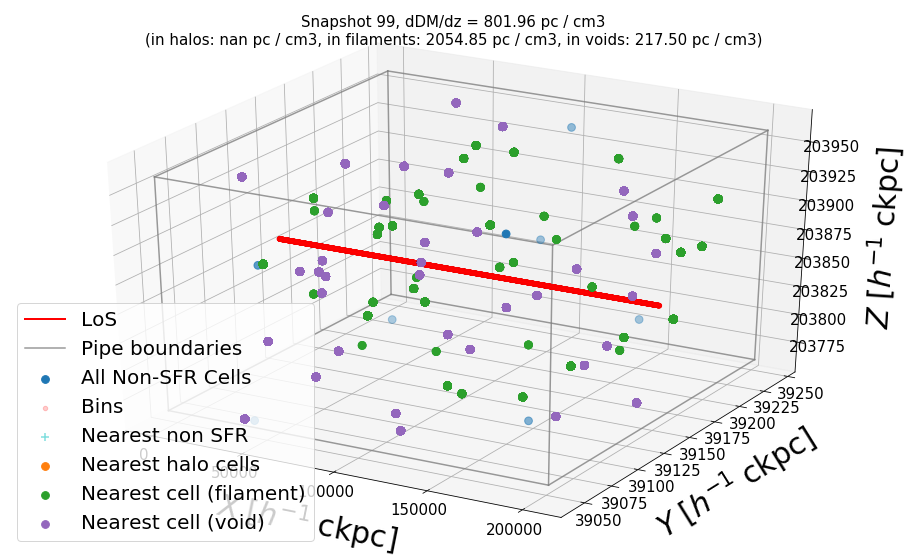

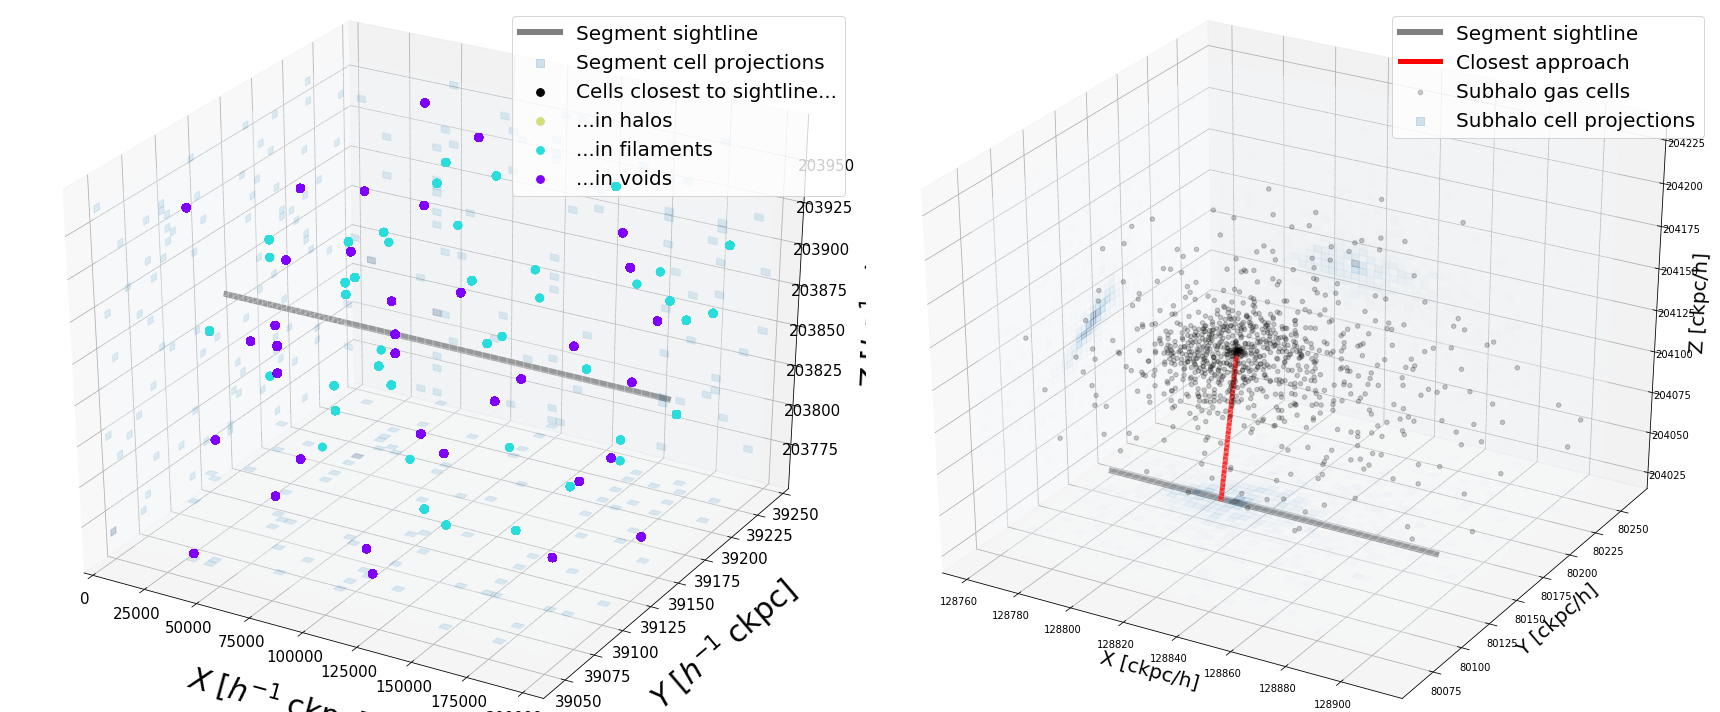

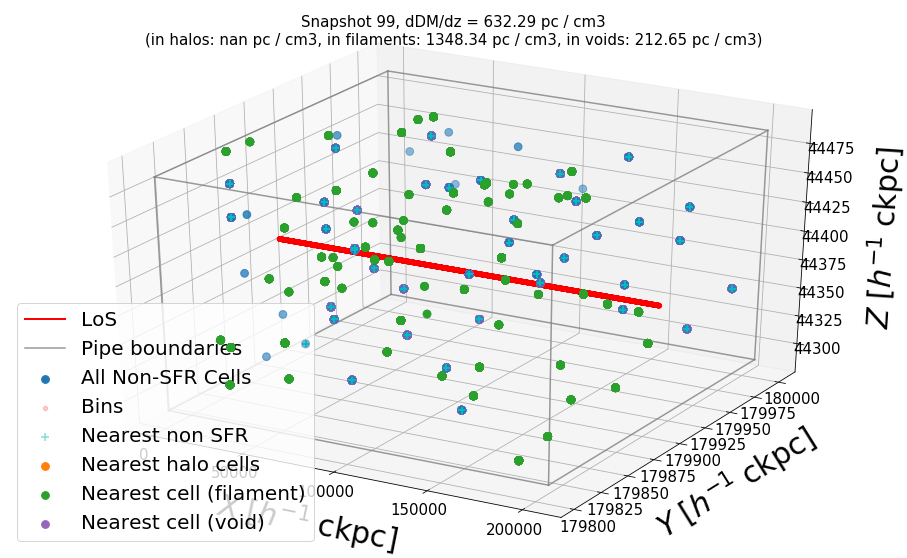

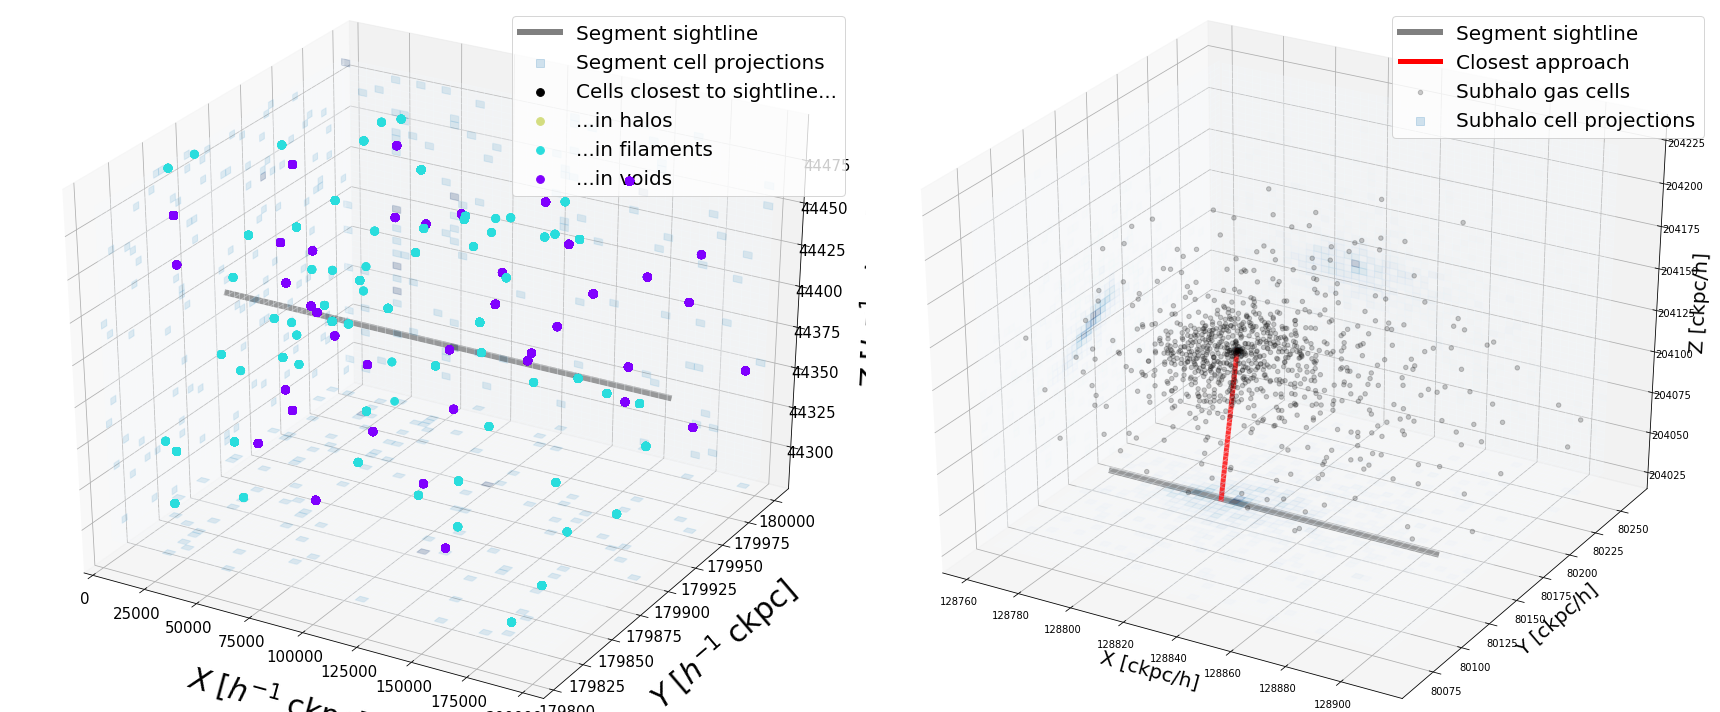

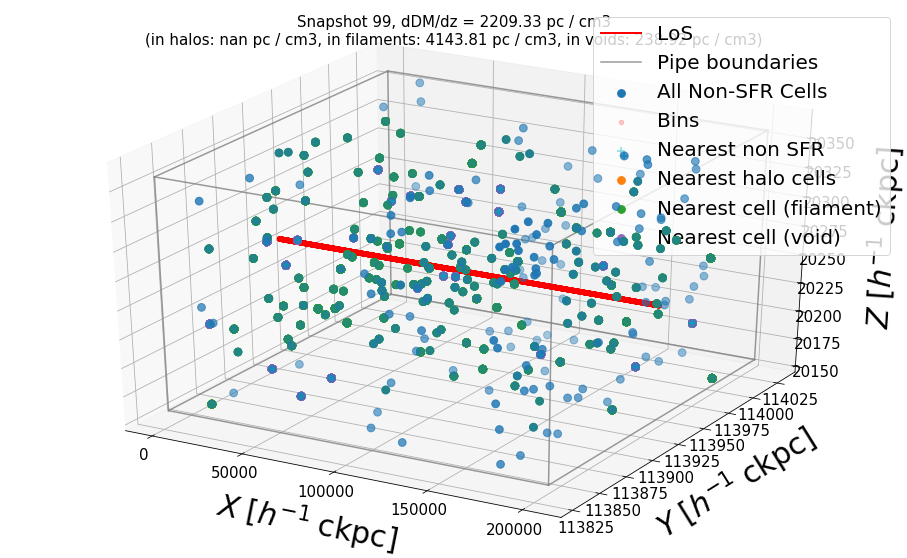

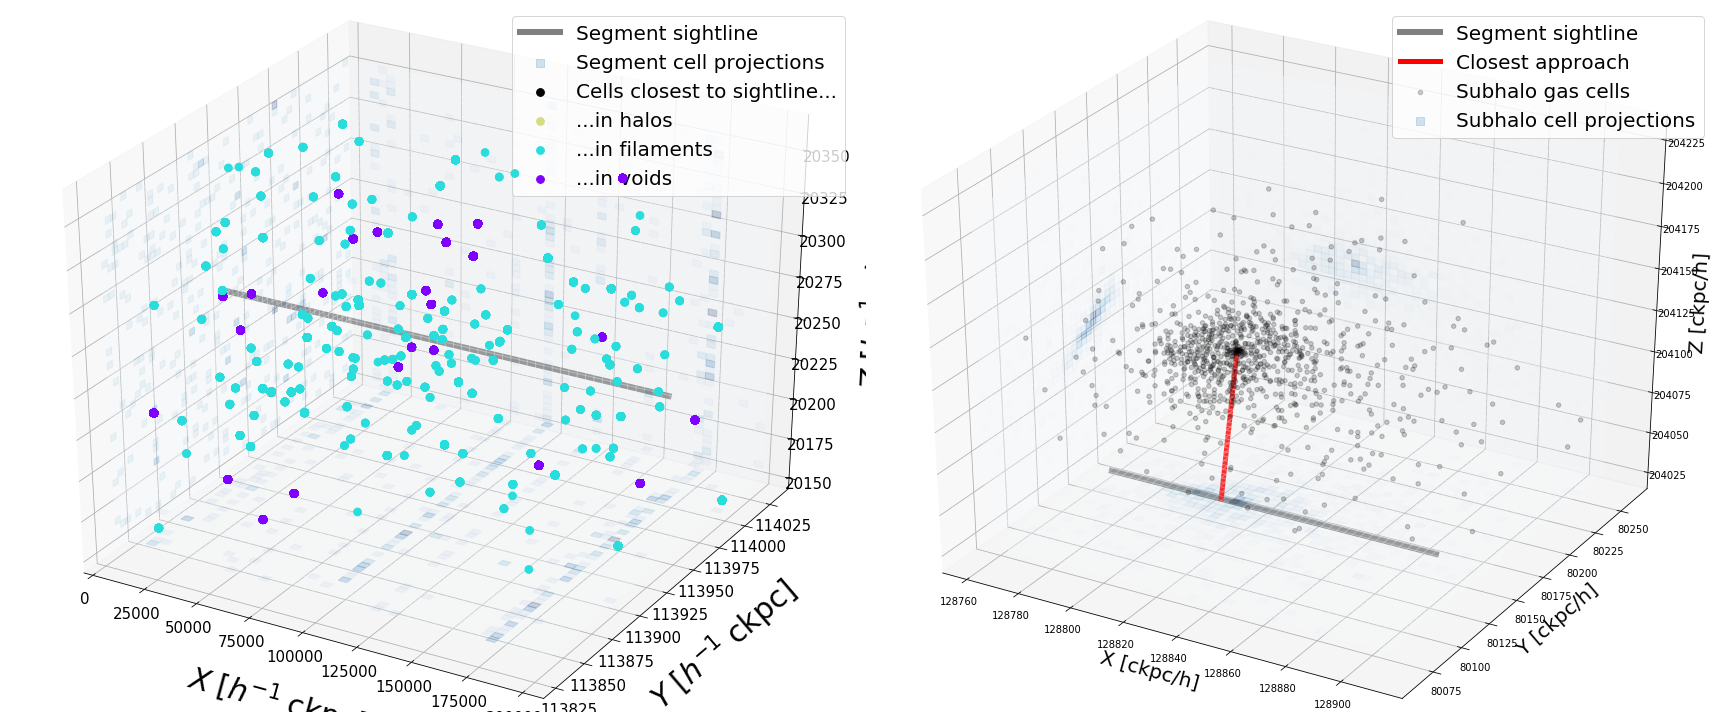

In [31]:


#############
#Create Pipe#
#############

for i in range(npipes): #for each desired pipe
    
    
    #########################
    #initialise check figure#
    #########################

    fig = plt.figure(figsize=(16,10))
    ax = fig.add_subplot(111,projection='3d')
    ax.set_xlim(0,header['BoxSize'])
    ax.set_xlabel('X [ckpc/h]',fontsize=15)
    ax.set_ylabel('Y [ckpc/h]',fontsize=15)
    ax.set_zlabel('Z [ckpc/h]',fontsize=15)

    #########################
    #initialise paper figure#
    #########################
    
    fig2 = plt.figure(figsize=(24,10))
    ax2 = fig2.add_subplot(121,projection='3d')
    ax2.set_xlim(0,header['BoxSize'])
    ax2.set_xlabel('X [ckpc/h]',fontsize=20)
    ax2.set_ylabel('Y [ckpc/h]',fontsize=20)
    ax2.set_zlabel('Z [ckpc/h]',fontsize=20)
    
    pipe_number = i
    print('Creating pipe {0}'.format(pipe_number))

    #########################################
    #define los coordinates at start of pipe#
    #########################################
    
    #By Zhang+20 definition of following x-axis,
    #x will be zero, y and z will be random
    #units default = ckpc/h (compare box size to https://www.tng-project.org/about/)
    
    pipe_start_coords = np.array([0,
                         np.random.uniform(0,header['BoxSize'],1)[0],
                         np.random.uniform(0,header['BoxSize'],1)[0]])
    #print('Random start cell coordinates: {0}'.format(pipe_start_coords))
    
    ###################################
    #define coordinates at end of pipe#
    ###################################
    
    #By Zhang+20 definition of following x-axis,
    #x will be length of simulation,y and z will be same as start coords
    
    pipe_end_coords = pipe_start_coords+np.array([header['BoxSize'],0,0])
    #print('Pipe end cell coordinates: {0}'.format(pipe_end_coords))

    ########################
    #plot the line of sight#
    ########################
    
    los_toplot=list(zip(pipe_start_coords,pipe_end_coords))
    #print(los_toplot)
    ax.plot(los_toplot[0],
            los_toplot[1],
            los_toplot[2],
            color='r',lw=2,label='LoS')

    
    ########################
    #construct pipe corners#
    ########################
    
    #Add and subtract half of pipe length from y and z coords for y and z boundaries
    #code adapted from https://stackoverflow.com/questions/33540109/plot-surfaces-on-a-cube
    
    c1s = pipe_start_coords + np.array([0,pipe_width/2,pipe_width/2]) #start corner 1
    c2s = pipe_start_coords + np.array([0,-pipe_width/2,-pipe_width/2]) #start corner 2
    c3s = pipe_start_coords + np.array([0,pipe_width/2,-pipe_width/2]) #start corner 3
    c4s = pipe_start_coords + np.array([0,-pipe_width/2,pipe_width/2]) #start corner 4
    
    c1e = pipe_end_coords + np.array([0,pipe_width/2,pipe_width/2]) #end corner 1
    c2e = pipe_end_coords + np.array([0,-pipe_width/2,-pipe_width/2]) #end corner 2
    c3e = pipe_end_coords + np.array([0,pipe_width/2,-pipe_width/2]) #end corner 3
    c4e = pipe_end_coords + np.array([0,-pipe_width/2,pipe_width/2]) #end corner 4
    
    corners = np.array([c1s,c2s,c3s,c4s,c1e,c2e,c3e,c4e])
    
    ######################
    #construct pipe edges#
    ######################

    line1 = list(zip(c1s,c1e))
    line2 = list(zip(c2s,c2e))
    line3 = list(zip(c3s,c3e))
    line4 = list(zip(c4s,c4e))
    line5 = list(zip(c1s,c3s))
    line6 = list(zip(c3s,c2s))
    line7 = list(zip(c2s,c4s))
    line8 = list(zip(c4s,c1s))
    line9 = list(zip(c1e,c3e))
    line10 = list(zip(c3e,c2e))
    line11 = list(zip(c2e,c4e))
    line12 = list(zip(c4e,c1e))
    
    lines_todraw = np.array([line1,line2,line3,line4,line5,line6,line7,line8,line9,line10,line11,line12])
    

    ###########
    #plot pipe#
    ###########
    
    for i in range(len(lines_todraw)):
        if i==0:
            ax.plot(lines_todraw[i][0],
                    lines_todraw[i][1],
                    lines_todraw[i][2],
                    color='gray',alpha=0.8,label='Pipe boundaries')
        else:
            ax.plot(lines_todraw[i][0],
                    lines_todraw[i][1],
                    lines_todraw[i][2],
                    color='gray',alpha=0.8)
            


    ########################
    #get cells in this pipe#
    ########################
    
    #adapted from https://stackoverflow.com/questions/42352622/finding-points-within-a-bounding-box-with-numpy
    #I think this is right but if I get any strange results, double check the theory
    
    yz_pts = dataPT0['Coordinates'][:,[1,2]] #all y and z coords
    #print('All y and z values: {0}'.format(yz_pts))

    ur = c1s[1:] #upper right of pipe start (y and z only)
    ll = c2e[1:] #lower left of pipe end (y and z only)
    #print('Upper right: {0}'.format(ur))
    #print('Lower left: {0}'.format(ll))

    inidx = np.all((ll <= yz_pts) & (yz_pts <= ur), axis=1) #indexes of cells in pipe
    
    ###########################
    #get data of cells in pipe#
    ###########################
    
    pipe_cell_coords = dataPT0['Coordinates'][inidx]       #coordinates [ckpc/h]
    pipe_cell_dens   = dataPT0['Density'][inidx]           #densities [(1e10Msun/h)/(ckpc/h)**3]
    pipe_cell_elab   = dataPT0['ElectronAbundance'][inidx] #electron abundance [-]
    pipe_cell_sfr    = dataPT0['StarFormationRate'][inidx] #star formation rate [Msun/yr]
    pipe_cell_dark   = dataPT0['SubfindDMDensity'][inidx]  #comoving dark matter density [(1e10Msun/h)/(ckpc/h)**3]
    
    #print('{0} cells in this pipe'.format(dataPT0['Coordinates'][inidx].shape[0]))

    ###############################
    #plot locations of these cells#
    ###############################
    
    #paper version
    x = pipe_cell_coords[:,0]
    y = pipe_cell_coords[:,1]
    z = pipe_cell_coords[:,2]
    
    ##PROJECTIONS OF ALL CELLS IN PIPE##
    
    ##
    
    test_h, test_yedges, test_zedges = np.histogram2d(y, z, bins=50)
    test_h = test_h.transpose()
    test_normalized_map = plt.cm.Blues(test_h/test_h.max())

    test_yy, test_zz = np.meshgrid(test_yedges, test_zedges)
    test_xpos = min(x)-2 # Plane of histogram
    test_xflat = np.full_like(test_yy, test_xpos) 

    ax2.plot_surface(test_xflat, test_yy, test_zz, facecolors=test_normalized_map, alpha=0.2,rstride=1, cstride=1, shade=False,zorder=0)
    ##
    
    test_h, test_xedges, test_zedges = np.histogram2d(x, z, bins=50)
    test_h = test_h.transpose()
    test_normalized_map = plt.cm.Blues(test_h/test_h.max())

    test_xx, test_zz = np.meshgrid(test_xedges, test_zedges)
    test_ypos = max(y)-2 # Plane of histogram
    test_yflat = np.full_like(test_xx, test_ypos) 

    ax2.plot_surface(test_xx, test_yflat, test_zz, facecolors=test_normalized_map, alpha=0.2,rstride=1, cstride=1, shade=False,zorder=0)
    
    
    ##
    
    test_h, test_xedges, test_yedges = np.histogram2d(x, y, bins=50)
    test_h = test_h.transpose()
    test_normalized_map = plt.cm.Blues(test_h/test_h.max())

    test_xx, test_yy = np.meshgrid(test_xedges, test_yedges)
    test_zpos = min(z)-2 # Plane of histogram
    test_zflat = np.full_like(test_xx, test_zpos) 

    ax2.plot_surface(test_xx, test_yy, test_zflat, facecolors=test_normalized_map, alpha=0.2,rstride=1, cstride=1, shade=False,zorder=0)
    
   
    
    ############################################################
    #For pure Zhang+20 method, exclude all star forming regions#
    ############################################################
    
    pipe_cell_coords_z = pipe_cell_coords[np.where(pipe_cell_sfr==0)]
    pipe_cell_dens_z = pipe_cell_dens[np.where(pipe_cell_sfr==0)]
    pipe_cell_elab_z = pipe_cell_elab[np.where(pipe_cell_sfr==0)]
    pipe_cell_sfr_z = pipe_cell_sfr[np.where(pipe_cell_sfr==0)]
    pipe_cell_dark_z = pipe_cell_dark[np.where(pipe_cell_sfr==0)]
    
    #print('sum for star forming check: {0}'.format(pipe_cell_sfr_z.sum()))
    
    ###############################
    #plot locations of these cells#
    ###############################
    
    ax.scatter3D(pipe_cell_coords_z[:,0],
                 pipe_cell_coords_z[:,1],
                 pipe_cell_coords_z[:,2],
                 label='All Non-SFR Cells',s=60,color='C0',marker='o')
    
    ###############################################
    #divide pipe into 10,000 bins along the x-axis#
    ###############################################
    
    #Question: why 10,000 bins given there are so few particles in the pipe?
    
    pipe_x_bins = np.linspace(pipe_start_coords[0],pipe_end_coords[0],nbins)
    #print('Pipe x-axis bin coordinates: {0} ckpc/h'.format(pipe_x_bins))
    
    #######################################
    #get coordinates of center of each bin#
    #######################################
    
    pipe_bin_coords = np.array([[i,pipe_start_coords[1],pipe_start_coords[2]]for i in pipe_x_bins])
    #print('Pipe x-bin_coords: {0}'.format(pipe_bin_coords))
    
    #plot locations of these bins
    ax.scatter3D(pipe_bin_coords[:,0],
             pipe_bin_coords[:,1],
             pipe_bin_coords[:,2],
             label='Bins',color='r',alpha=0.2)
    
    #paper version
    ax2.plot(pipe_bin_coords[:,0],
             pipe_bin_coords[:,1],
             pipe_bin_coords[:,2],
             color='gray',lw=6,label='Segment sightline',alpha=1)
    
    ###############################################################
    #for each bin, find distance between it and every cell in pipe#
    #find the one with miniimum distance                          #
    #this will be the cell in the los                             #
    #do for zhang (excluding sfr) and non-zhang (including sfr)   #
    ###############################################################
    
    ###########
    #non-zhang#
    ###########
    
    #initialise empty array to hold indices of closest particle to each bin
    nearest_idxs = []
    
    for i in range(len(pipe_bin_coords)): #loop over bins
        coords = pipe_bin_coords[i] #get bin coordinates
        distarr = np.sqrt(np.sum(((pipe_cell_coords[:]-coords)**2),axis=1)) #create array of distances from cells
        nearest = np.argmin(distarr) #find nearest cell to bin
        nearest_idxs.append(nearest) #append to array
        
    nearest_idxs = np.array(nearest_idxs) #convert to numpy array
    nearest_idxs_unique = np.unique(nearest_idxs) #some cells are the closest to multiple bins. Get uniques.
    
    ##############
    #zhang method#
    ##############
    
    #initialise empty array to hold indices of closest particle to each bin
    nearest_idxs_z = []
    
    for i in range(len(pipe_bin_coords)): #loop over bins
        coords = pipe_bin_coords[i] #get bin coordinates
        distarr = np.sqrt(np.sum(((pipe_cell_coords_z[:]-coords)**2),axis=1)) #create array of distances from cells
        nearest = np.argmin(distarr) #find nearest cell to bin
        nearest_idxs_z.append(nearest) #append to array
        
    nearest_idxs_z = np.array(nearest_idxs_z) #convert to numpy array
    nearest_idxs_unique_z = np.unique(nearest_idxs_z) #some cells are the closest to multiple bins. Get uniques.
    
    #print('Nearest {0} particle ids: {1}'.format(np.shape(nearest_idxs),nearest_idxs))
    #print('Of these, {0} are unique: {1}'.format(np.shape(nearest_idxs_unique),nearest_idxs_unique))
    
    #################################
    #extract data from nearest cells#
    #################################
    
    ###########
    #non-zhang#
    ###########
    
    pipe_nearest_coords = np.array(pipe_cell_coords[nearest_idxs]) #coordinates [ckpc/h]
    pipe_nearest_dens   = np.array(pipe_cell_dens[nearest_idxs])   #densities [(1e10Msun/h)/(ckpc/h)**3]
    pipe_nearest_elab   = np.array(pipe_cell_elab[nearest_idxs])   #electron abundance [-]
    pipe_nearest_sfr    = np.array(pipe_cell_sfr[nearest_idxs])    #star formation rate [Msun/yr]
    pipe_nearest_dark   = np.array(pipe_cell_dark[nearest_idxs])   #comooving dark matter density [(1e10Msun/h)/(ckpc/h)**3]
    
    #######
    #zhang#
    #######
    pipe_nearest_coords_z = np.array(pipe_cell_coords_z[nearest_idxs_z]) #coordinates [ckpc/h]
    pipe_nearest_dens_z   = np.array(pipe_cell_dens_z[nearest_idxs_z])   #densities [(1e10Msun/h)/(ckpc/h)**3]
    pipe_nearest_elab_z   = np.array(pipe_cell_elab_z[nearest_idxs_z])   #electron abundance [-]
    pipe_nearest_sfr_z    = np.array(pipe_cell_sfr_z[nearest_idxs_z])    #star formation rate [Msun/yr]
    pipe_nearest_dark_z   = np.array(pipe_cell_dark_z[nearest_idxs_z])   #comooving dark matter density [(1e10Msun/h)/(ckpc/h)**3]
    
    #mark locations of nearest cells to bins on plot
    #ax.scatter3D(pipe_nearest_coords[:,0],
    #         pipe_nearest_coords[:,1],
    #         pipe_nearest_coords[:,2],
    #         label='Nearest',color='k',marker='x',s=50)
    
    ax.scatter3D(pipe_nearest_coords_z[:,0],
             pipe_nearest_coords_z[:,1],
             pipe_nearest_coords_z[:,2],
             label='Nearest non SFR',color='C',marker='+',s=50,alpha=0.5,zorder=2)

    ###############################################
    #convert density to si units using artale code#
    ###############################################
    
    pipe_nearest_dens_si = TNG_Dens2SI_astropy(pipe_nearest_dens)    
    pipe_nearest_dens_z_si = TNG_Dens2SI_astropy(pipe_nearest_dens_z)
    
    ###########################################################
    #convert dark matter density to si units using artale code#
    ###########################################################
    
    pipe_nearest_dark_si = TNG_Dens2SI_astropy(pipe_nearest_dark)    
    pipe_nearest_dark_z_si = TNG_Dens2SI_astropy(pipe_nearest_dark_z) 
    
    #########################################################################
    #divide dark matter density by critical density to create the LSS tracer#
    #########################################################################
    
    pipe_nearest_LSStracer = pipe_nearest_dark_si/my_dens_crit
    pipe_nearest_LSStracer_z = pipe_nearest_dark_z_si/my_dens_crit
    #print('The structure tracer array is {0}'.format(pipe_nearest_LSStracer_z))
    
    ##########################################
    #Create Large-Scale Structure (LSS) masks#
    ##########################################
    
    #non-zhang
    voi_mask_PT0 = pipe_nearest_LSStracer < 0.1
    fil_mask_PT0 = np.logical_and(pipe_nearest_LSStracer >= 0.1, pipe_nearest_LSStracer < 57)#CELESTE:CORRECTED
    hal_mask_PT0 = pipe_nearest_LSStracer >= 57 
    
    #zhang
    voi_mask_PT0_z = pipe_nearest_LSStracer_z < 0.1
    fil_mask_PT0_z = np.logical_and(pipe_nearest_LSStracer_z >= 0.1, pipe_nearest_LSStracer_z < 57)#CELESTE:CORRECTED
    hal_mask_PT0_z = pipe_nearest_LSStracer_z >= 57 
    
    #################################################
    #plot each structure type as a separate colour#
    #################################################

    ax2.scatter3D(pipe_nearest_coords_z[fil_mask_PT0_z][0,0],
              pipe_nearest_coords_z[fil_mask_PT0_z][0,1],
              pipe_nearest_coords_z[fil_mask_PT0_z][0,2],
              marker='s',color='C0',s=60,alpha=0.2,label='Segment cell projections')
    ax2.scatter3D(pipe_nearest_coords_z[fil_mask_PT0_z][0,0],
              pipe_nearest_coords_z[fil_mask_PT0_z][0,1],
              pipe_nearest_coords_z[fil_mask_PT0_z][0,2],
              marker='o',color='k',s=60,alpha=1,label='Cells closest to sightline...') 
    
    #halos
    ax.scatter3D(pipe_nearest_coords_z[hal_mask_PT0_z][:,0],
             pipe_nearest_coords_z[hal_mask_PT0_z][:,1],
             pipe_nearest_coords_z[hal_mask_PT0_z][:,2],
             label='Nearest halo cells',color='C1',marker='o',s=60,alpha=1)
    #paper version
    ax2.scatter3D(pipe_nearest_coords_z[hal_mask_PT0_z][:,0],
             pipe_nearest_coords_z[hal_mask_PT0_z][:,1],
             pipe_nearest_coords_z[hal_mask_PT0_z][:,2],
             label='...in halos',color='C3',marker='o',s=60,alpha=1)
    
    #filaments
    ax.scatter3D(pipe_nearest_coords_z[fil_mask_PT0_z][:,0],
             pipe_nearest_coords_z[fil_mask_PT0_z][:,1],
             pipe_nearest_coords_z[fil_mask_PT0_z][:,2],
             label='Nearest cell (filament)',color='C2',marker='o',s=60,alpha=1)
    #paper version
    ax2.scatter3D(pipe_nearest_coords_z[fil_mask_PT0_z][:,0],
             pipe_nearest_coords_z[fil_mask_PT0_z][:,1],
             pipe_nearest_coords_z[fil_mask_PT0_z][:,2],
             label='...in filaments',color='C4',marker='o',s=60,alpha=1)    
    #voids
    ax.scatter3D(pipe_nearest_coords_z[voi_mask_PT0_z][:,0],
             pipe_nearest_coords_z[voi_mask_PT0_z][:,1],
             pipe_nearest_coords_z[voi_mask_PT0_z][:,2],
             label='Nearest cell (void)',color='C4',marker='o',s=60,alpha=1)
    #paper version
    ax2.scatter3D(pipe_nearest_coords_z[voi_mask_PT0_z][:,0],
             pipe_nearest_coords_z[voi_mask_PT0_z][:,1],
             pipe_nearest_coords_z[voi_mask_PT0_z][:,2],
             label='...in voids',color='C5',marker='o',s=60,alpha=1)   
    
    
    ##########################################
    #get electron density at each of the bins#
    ##########################################
    
    #follow zhang+20 equation exactly as native units of TNG are
    #comoving
    
    #############################################################
    #Zhang: pne = (ElAb)*hmasssfrac*(Dens/protonmass)*((1+z)**3)#
    #use data which excludes SFRs                               #
    #############################################################
    
    #total
    pipe_nearest_pne_z = (pipe_nearest_elab_z)*hmassfrac*(pipe_nearest_dens_z_si/protonmass)*((1+header['Redshift'])**3)
    #print('pnes are: {0}'.format(pipe_nearest_pne_z))

    #halos
    pipe_nearest_pne_z_hal = (pipe_nearest_elab_z[hal_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[hal_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
    #print('pnes in halos are: {0}'.format(pipe_nearest_pne_z_hal))
    
    #filaments
    pipe_nearest_pne_z_fil = (pipe_nearest_elab_z[fil_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[fil_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
    #print('pnes in filaments are: {0}'.format(pipe_nearest_pne_z_fil))
    
    #voids
    pipe_nearest_pne_z_voi = (pipe_nearest_elab_z[voi_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[voi_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
    #print('pnes in voids are: {0}'.format(pipe_nearest_pne_z_voi))
    

    ######################################################################
    #Non-zhang: pne = (ElAb*Warm)*hmasssfrac*(Dens/protonmass)*((1+z)**3)#
    #use all data (sfr included) and warm mass fraction                  #
    ######################################################################    
    
    ##################################
    #average these electron densities#
    ##################################
    
    #Zhang method
    
    #total
    pipe_average_pne_z = np.mean(pipe_nearest_pne_z)
    #print('Average pne is: {0}'.format(pipe_average_pne_z))

    #halos
    pipe_average_pne_z_hal = np.mean(pipe_nearest_pne_z_hal)
    #print('Average pne in halos is: {0}'.format(pipe_average_pne_z_hal))
    
    #filaments
    pipe_average_pne_z_fil = np.mean(pipe_nearest_pne_z_fil)
    #print('Average pne in filaments is: {0}'.format(pipe_average_pne_z_fil))
    
    #voids
    pipe_average_pne_z_voi = np.mean(pipe_nearest_pne_z_voi)
    #print('Average pne in voids is: {0}'.format(pipe_average_pne_z_voi))
    
    ################################
    #calculate dDM/dz for this pipe#
    ################################
    
    #outer bit of eq 7
    outer=c.c/cosmosource.H(0)
    #print(outer)

    #E(z) according to paper eq 5
    Ez = np.sqrt((0.3089*((1+header['Redshift'])**(3)))+(0.6911))
    #print(Ez)
    
    #denominator of eq 7
    denominator = ((1+header['Redshift'])**(2))*Ez

    #remainder of equation 7
    
    #total
    edens_z = pipe_average_pne_z
    ddmdz_z = outer*edens_z/denominator
    
    #halos
    edens_z_hal = pipe_average_pne_z_hal
    ddmdz_z_hal = outer*edens_z_hal/denominator
    
    #filaments
    edens_z_fil = pipe_average_pne_z_fil
    ddmdz_z_fil = outer*edens_z_fil/denominator
    
    #voids
    edens_z_voi = pipe_average_pne_z_voi
    ddmdz_z_voi = outer*edens_z_voi/denominator
    
    #print('dDM/dz = {0}'.format(ddmdz_z.to('pc*cm**(-3)')))
    #print('dDM/dz in halos = {0}'.format(ddmdz_z_hal.to('pc*cm**(-3)')))
    #print('dDM/dz in filaments = {0}'.format(ddmdz_z_fil.to('pc*cm**(-3)')))
    #print('dDM/dz in voids = {0}'.format(ddmdz_z_voi.to('pc*cm**(-3)')))

    

    
    ax.set_title('Snapshot {0}, dDM/dz = {1:.2f}\n(in halos: {2:.2f}, in filaments: {3:.2f}, in voids: {4:.2f})'.format(snap_number,
                                                                                                                        ddmdz_z.to('pc*cm**(-3)'),
                                                                                                                        ddmdz_z_hal.to('pc*cm**(-3)'),
                                                                                                                        ddmdz_z_fil.to('pc*cm**(-3)'),
                                                                                                                        ddmdz_z_voi.to('pc*cm**(-3)')),fontsize=15)

    
    
    ax.legend(fontsize=20)
    #paper version
    ax2.legend(fontsize=20,loc=1)
    
    
    ##################
    #plot the subhalo#
    ##################
    

    ax3=fig2.add_subplot(122,projection='3d')
    #ax3.set_xlim(0,header['BoxSize'])
    ax3.set_xlabel('X [ckpc/h]',fontsize=20)
    ax3.set_ylabel('Y [ckpc/h]',fontsize=20)
    ax3.set_zlabel('Z [ckpc/h]',fontsize=20)

    ax3.scatter3D(sh_gas_coords[:,0],
                  sh_gas_coords[:,1],
                  sh_gas_coords[:,2],
                  label='Subhalo gas cells',
                  color='k',
                  alpha=0.2) #the subhalo

    #ax3.scatter3D(bin_coords[:,0],
    #              bin_coords[:,1],
    #              bin_coords[:,2],
    #              color='gray',
    #              lw=6,
    #              label='Segment sightline',alpha=1) #the los
    

    ax3.plot(bin_coords[:,0][np.where((bin_coords[:,0]>np.amin(sh_gas_coords[:,0])) & (bin_coords[:,0]<np.amax(sh_gas_coords[:,0])))],
             bin_coords[:,1][np.where((bin_coords[:,0]>np.amin(sh_gas_coords[:,0])) & (bin_coords[:,0]<np.amax(sh_gas_coords[:,0])))],
             bin_coords[:,2][np.where((bin_coords[:,0]>np.amin(sh_gas_coords[:,0])) & (bin_coords[:,0]<np.amax(sh_gas_coords[:,0])))],
             color='gray',
             lw=6,
             ls='-',
             markersize=15,
             label='Segment sightline',alpha=1) #the los (but only zoomed in around the galaxy)

    ##PLOT PROJECTION OF ALL CELLS IN THE SUBHALO##

    x = sh_gas_coords[:,0]
    y = sh_gas_coords[:,1]
    z = sh_gas_coords[:,2]

    #ax2.set_xlim(np.amin(sh_gas_coords[:,0]),
    #np.amax(sh_gas_coords[:,0]))

    ##

    test_h, test_yedges, test_zedges = np.histogram2d(y, z, bins=50)
    test_h = test_h.transpose()
    test_normalized_map = plt.cm.Blues(test_h/test_h.max())

    test_yy, test_zz = np.meshgrid(test_yedges, test_zedges)
    test_xpos = min(x)-2 # Plane of histogram
    test_xflat = np.full_like(test_yy, test_xpos) 

    ax3.plot_surface(test_xflat, test_yy, test_zz, facecolors=test_normalized_map, alpha=0.2,rstride=1, cstride=1, shade=False,zorder=0)
    ##

    test_h, test_xedges, test_zedges = np.histogram2d(x, z, bins=50)
    test_h = test_h.transpose()
    test_normalized_map = plt.cm.Blues(test_h/test_h.max())

    test_xx, test_zz = np.meshgrid(test_xedges, test_zedges)
    test_ypos = max(y)-2 # Plane of histogram
    test_yflat = np.full_like(test_xx, test_ypos) 

    ax3.plot_surface(test_xx, test_yflat, test_zz, facecolors=test_normalized_map, alpha=0.2,rstride=1, cstride=1, shade=False,zorder=0)

    
    ax3.scatter3D(sh_gas_coords[0,0],
          sh_gas_coords[0,1],
          sh_gas_coords[0,2],
          marker='s',color='C0',s=60,alpha=0.2,label='Subhalo cell projections')

    ##

    test_h, test_xedges, test_yedges = np.histogram2d(x, y, bins=50)
    test_h = test_h.transpose()
    test_normalized_map = plt.cm.Blues(test_h/test_h.max())

    test_xx, test_yy = np.meshgrid(test_xedges, test_yedges)
    test_zpos = min(z)-2 # Plane of histogram
    test_zflat = np.full_like(test_xx, test_zpos) 

    ax3.plot_surface(test_xx, test_yy, test_zflat, facecolors=test_normalized_map, alpha=0.2,rstride=1, cstride=1, shade=False,zorder=0)

    

    ax3.plot(list(zip(sh_centpos,minDist_xyz))[0],
            list(zip(sh_centpos,minDist_xyz))[1],
            list(zip(sh_centpos,minDist_xyz))[2],
           color='r',lw=5,label='Closest approach') #the impact factor

    ax3.legend(fontsize=20,loc=1)
    fig2.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout()    

    ax2.dist=9
    ax3.dist=9

    
    fig2.savefig('./Paper_Pipe_Plots_2/out_{0}.png'.format(pipe_number),format='png')

# New version for paper

In [41]:
npipes  = 3000#1500 #number of pipes to create and plot

In [ ]:
from matplotlib.collections import PathCollection
from matplotlib.legend_handler import HandlerPathCollection, HandlerLine2D
col = plt.cm.rainbow(np.linspace(0,1,4)) #create a list of colours from the colourmap which match those from plot in Paper_Plots_IF_vs_DM_3.ipynb

#############
#Create Pipe#
#############

for i in range(npipes): #for each desired pipe
    
    
    #########################
    #initialise check figure#
    #########################

    fig = plt.figure(figsize=(32,20))
    ax = fig.add_subplot(111,projection='3d')
    #ax.set_xlim(0,header['BoxSize'])
    #ax.set_xlabel('X [ckpc/h]',fontsize=15)
    #ax.set_ylabel('Y [ckpc/h]',fontsize=15)
    #ax.set_zlabel('Z [ckpc/h]',fontsize=15)
    
    ax.set_xlabel(r'$X\;[h^{-1}\;{\rm ckpc}]$',fontsize=30,labelpad=25)
    ax.set_ylabel(r'$Y\;[h^{-1}\;{\rm ckpc}]$',fontsize=30,labelpad=25)
    ax.set_zlabel(r'$Z\;[h^{-1}\;{\rm ckpc}]$',fontsize=30,labelpad=25)
    ax.tick_params(axis='both', which='major', labelsize=15)

    #########################
    #initialise paper figure#
    #########################
    
    fig2 = plt.figure(figsize=(30,10))
    ax2 = fig2.add_subplot(121,projection='3d')
    ax2.set_xlim(0,header['BoxSize'])
    #ax2.set_xlabel('X [ckpc/h]',fontsize=20)
    #ax2.set_ylabel('Y [ckpc/h]',fontsize=20)
    #ax2.set_zlabel('Z [ckpc/h]',fontsize=20)
    
    #ax2.set_xlabel(r'$X\;[h^{-1}\;{\rm ckpc}]$',fontsize=30,labelpad=25)
    #ax2.set_ylabel(r'$Y\;[h^{-1}\;{\rm ckpc}]$',fontsize=30,labelpad=25)
    #ax2.set_zlabel(r'$Z\;[h^{-1}\;{\rm ckpc}]$',fontsize=30,labelpad=25)
    
    #Note: as pf 01/06/2023 we have included a bit at the end of the plot which divides
    #the axes ticks by 1000 to put everything in terms of cMpc/h
    ax2.set_xlabel(r'$X\;[h^{-1}\;{\rm cMpc}]$',fontsize=30,labelpad=25)
    ax2.set_ylabel(r'$Y\;[h^{-1}\;{\rm cMpc}]$',fontsize=30,labelpad=25)
    ax2.set_zlabel(r'$Z\;[h^{-1}\;{\rm cMpc}]$',fontsize=30,labelpad=25)
    
    ax2.tick_params(axis='both', which='major', labelsize=15)
    
    pipe_number = i
    print('Creating pipe {0}'.format(pipe_number))

    #########################################
    #define los coordinates at start of pipe#
    #########################################
    
    #By Zhang+20 definition of following x-axis,
    #x will be zero, y and z will be random
    #units default = ckpc/h (compare box size to https://www.tng-project.org/about/)
    
    pipe_start_coords = np.array([0,
                         np.random.uniform(0,header['BoxSize'],1)[0],
                         np.random.uniform(0,header['BoxSize'],1)[0]])
    #print('Random start cell coordinates: {0}'.format(pipe_start_coords))
    
    ###################################
    #define coordinates at end of pipe#
    ###################################
    
    #By Zhang+20 definition of following x-axis,
    #x will be length of simulation,y and z will be same as start coords
    
    pipe_end_coords = pipe_start_coords+np.array([header['BoxSize'],0,0])
    #print('Pipe end cell coordinates: {0}'.format(pipe_end_coords))

    ########################
    #plot the line of sight#
    ########################
    
    los_toplot=list(zip(pipe_start_coords,pipe_end_coords))
    #print(los_toplot)
    ax.plot(los_toplot[0],
            los_toplot[1],
            los_toplot[2],
            color='r',lw=2,label='LoS')

    
    ########################
    #construct pipe corners#
    ########################
    
    #Add and subtract half of pipe length from y and z coords for y and z boundaries
    #code adapted from https://stackoverflow.com/questions/33540109/plot-surfaces-on-a-cube
    
    c1s = pipe_start_coords + np.array([0,pipe_width/2,pipe_width/2]) #start corner 1
    c2s = pipe_start_coords + np.array([0,-pipe_width/2,-pipe_width/2]) #start corner 2
    c3s = pipe_start_coords + np.array([0,pipe_width/2,-pipe_width/2]) #start corner 3
    c4s = pipe_start_coords + np.array([0,-pipe_width/2,pipe_width/2]) #start corner 4
    
    c1e = pipe_end_coords + np.array([0,pipe_width/2,pipe_width/2]) #end corner 1
    c2e = pipe_end_coords + np.array([0,-pipe_width/2,-pipe_width/2]) #end corner 2
    c3e = pipe_end_coords + np.array([0,pipe_width/2,-pipe_width/2]) #end corner 3
    c4e = pipe_end_coords + np.array([0,-pipe_width/2,pipe_width/2]) #end corner 4
    
    corners = np.array([c1s,c2s,c3s,c4s,c1e,c2e,c3e,c4e])
    
    ######################
    #construct pipe edges#
    ######################

    line1 = list(zip(c1s,c1e))
    line2 = list(zip(c2s,c2e))
    line3 = list(zip(c3s,c3e))
    line4 = list(zip(c4s,c4e))
    line5 = list(zip(c1s,c3s))
    line6 = list(zip(c3s,c2s))
    line7 = list(zip(c2s,c4s))
    line8 = list(zip(c4s,c1s))
    line9 = list(zip(c1e,c3e))
    line10 = list(zip(c3e,c2e))
    line11 = list(zip(c2e,c4e))
    line12 = list(zip(c4e,c1e))
    
    lines_todraw = np.array([line1,line2,line3,line4,line5,line6,line7,line8,line9,line10,line11,line12])
    

    ###########
    #plot pipe#
    ###########
    
    for i in range(len(lines_todraw)):
        if i==0:
            ax.plot(lines_todraw[i][0],
                    lines_todraw[i][1],
                    lines_todraw[i][2],
                    color='gray',alpha=0.8,label='Pipe boundaries')
        else:
            ax.plot(lines_todraw[i][0],
                    lines_todraw[i][1],
                    lines_todraw[i][2],
                    color='gray',alpha=0.8)
            


    ########################
    #get cells in this pipe#
    ########################
    
    #adapted from https://stackoverflow.com/questions/42352622/finding-points-within-a-bounding-box-with-numpy
    #I think this is right but if I get any strange results, double check the theory
    
    yz_pts = dataPT0['Coordinates'][:,[1,2]] #all y and z coords
    #print('All y and z values: {0}'.format(yz_pts))

    ur = c1s[1:] #upper right of pipe start (y and z only)
    ll = c2e[1:] #lower left of pipe end (y and z only)
    #print('Upper right: {0}'.format(ur))
    #print('Lower left: {0}'.format(ll))

    inidx = np.all((ll <= yz_pts) & (yz_pts <= ur), axis=1) #indexes of cells in pipe
    
    ###########################
    #get data of cells in pipe#
    ###########################
    
    pipe_cell_coords = dataPT0['Coordinates'][inidx]       #coordinates [ckpc/h]
    pipe_cell_dens   = dataPT0['Density'][inidx]           #densities [(1e10Msun/h)/(ckpc/h)**3]
    pipe_cell_elab   = dataPT0['ElectronAbundance'][inidx] #electron abundance [-]
    pipe_cell_sfr    = dataPT0['StarFormationRate'][inidx] #star formation rate [Msun/yr]
    pipe_cell_dark   = dataPT0['SubfindDMDensity'][inidx]  #comoving dark matter density [(1e10Msun/h)/(ckpc/h)**3]
    
    #print('{0} cells in this pipe'.format(dataPT0['Coordinates'][inidx].shape[0]))

    ###############################
    #plot locations of these cells#
    ###############################
    
    #paper version
    x = pipe_cell_coords[:,0]
    y = pipe_cell_coords[:,1]
    z = pipe_cell_coords[:,2]
    
    ##PROJECTIONS OF ALL CELLS IN PIPE##
    
    ##
    
    test_h, test_yedges, test_zedges = np.histogram2d(y, z, bins=50)
    test_h = test_h.transpose()
    test_normalized_map = plt.cm.Blues(test_h/test_h.max())

    test_yy, test_zz = np.meshgrid(test_yedges, test_zedges)
    test_xpos = min(x)-2 # Plane of histogram
    test_xflat = np.full_like(test_yy, test_xpos) 

    ax2.plot_surface(test_xflat, test_yy, test_zz, facecolors=test_normalized_map, alpha=0.2,rstride=1, cstride=1, shade=False,zorder=0)
    ##
    
    test_h, test_xedges, test_zedges = np.histogram2d(x, z, bins=50)
    test_h = test_h.transpose()
    test_normalized_map = plt.cm.Blues(test_h/test_h.max())

    test_xx, test_zz = np.meshgrid(test_xedges, test_zedges)
    test_ypos = max(y)-2 # Plane of histogram
    test_yflat = np.full_like(test_xx, test_ypos) 

    ax2.plot_surface(test_xx, test_yflat, test_zz, facecolors=test_normalized_map, alpha=0.2,rstride=1, cstride=1, shade=False,zorder=0)
    
    
    ##
    
    test_h, test_xedges, test_yedges = np.histogram2d(x, y, bins=50)
    test_h = test_h.transpose()
    test_normalized_map = plt.cm.Blues(test_h/test_h.max())

    test_xx, test_yy = np.meshgrid(test_xedges, test_yedges)
    test_zpos = min(z)-2 # Plane of histogram
    test_zflat = np.full_like(test_xx, test_zpos) 

    ax2.plot_surface(test_xx, test_yy, test_zflat, facecolors=test_normalized_map, alpha=0.2,rstride=1, cstride=1, shade=False,zorder=0)
    
   
    
    ############################################################
    #For pure Zhang+20 method, exclude all star forming regions#
    ############################################################
    
    pipe_cell_coords_z = pipe_cell_coords[np.where(pipe_cell_sfr==0)]
    pipe_cell_dens_z = pipe_cell_dens[np.where(pipe_cell_sfr==0)]
    pipe_cell_elab_z = pipe_cell_elab[np.where(pipe_cell_sfr==0)]
    pipe_cell_sfr_z = pipe_cell_sfr[np.where(pipe_cell_sfr==0)]
    pipe_cell_dark_z = pipe_cell_dark[np.where(pipe_cell_sfr==0)]
    
    #print('sum for star forming check: {0}'.format(pipe_cell_sfr_z.sum()))
    
    ###############################
    #plot locations of these cells#
    ###############################
    
    ax.scatter3D(pipe_cell_coords_z[:,0],
                 pipe_cell_coords_z[:,1],
                 pipe_cell_coords_z[:,2],
                 label='All Non-SFR Cells',s=60,color='C0',marker='o')
    
    ###############################################
    #divide pipe into 10,000 bins along the x-axis#
    ###############################################
    
    #Question: why 10,000 bins given there are so few particles in the pipe?
    
    pipe_x_bins = np.linspace(pipe_start_coords[0],pipe_end_coords[0],nbins)
    #print('Pipe x-axis bin coordinates: {0} ckpc/h'.format(pipe_x_bins))
    
    #######################################
    #get coordinates of center of each bin#
    #######################################
    
    pipe_bin_coords = np.array([[i,pipe_start_coords[1],pipe_start_coords[2]]for i in pipe_x_bins])
    #print('Pipe x-bin_coords: {0}'.format(pipe_bin_coords))
    
    #plot locations of these bins
    ax.scatter3D(pipe_bin_coords[:,0],
             pipe_bin_coords[:,1],
             pipe_bin_coords[:,2],
             label='Bins',color='r',alpha=0.2)
    
    #paper version
    ax2.plot(pipe_bin_coords[:,0],
             pipe_bin_coords[:,1],
             pipe_bin_coords[:,2],
             color='gray',lw=6,label='Segment sightline',alpha=1)
    
    ###############################################################
    #for each bin, find distance between it and every cell in pipe#
    #find the one with miniimum distance                          #
    #this will be the cell in the los                             #
    #do for zhang (excluding sfr) and non-zhang (including sfr)   #
    ###############################################################
    
    ###########
    #non-zhang#
    ###########
    
    #initialise empty array to hold indices of closest particle to each bin
    nearest_idxs = []
    
    for i in range(len(pipe_bin_coords)): #loop over bins
        coords = pipe_bin_coords[i] #get bin coordinates
        distarr = np.sqrt(np.sum(((pipe_cell_coords[:]-coords)**2),axis=1)) #create array of distances from cells
        nearest = np.argmin(distarr) #find nearest cell to bin
        nearest_idxs.append(nearest) #append to array
        
    nearest_idxs = np.array(nearest_idxs) #convert to numpy array
    nearest_idxs_unique = np.unique(nearest_idxs) #some cells are the closest to multiple bins. Get uniques.
    
    ##############
    #zhang method#
    ##############
    
    #initialise empty array to hold indices of closest particle to each bin
    nearest_idxs_z = []
    
    for i in range(len(pipe_bin_coords)): #loop over bins
        coords = pipe_bin_coords[i] #get bin coordinates
        distarr = np.sqrt(np.sum(((pipe_cell_coords_z[:]-coords)**2),axis=1)) #create array of distances from cells
        nearest = np.argmin(distarr) #find nearest cell to bin
        nearest_idxs_z.append(nearest) #append to array
        
    nearest_idxs_z = np.array(nearest_idxs_z) #convert to numpy array
    nearest_idxs_unique_z = np.unique(nearest_idxs_z) #some cells are the closest to multiple bins. Get uniques.
    
    #print('Nearest {0} particle ids: {1}'.format(np.shape(nearest_idxs),nearest_idxs))
    #print('Of these, {0} are unique: {1}'.format(np.shape(nearest_idxs_unique),nearest_idxs_unique))
    
    #################################
    #extract data from nearest cells#
    #################################
    
    ###########
    #non-zhang#
    ###########
    
    pipe_nearest_coords = np.array(pipe_cell_coords[nearest_idxs]) #coordinates [ckpc/h]
    pipe_nearest_dens   = np.array(pipe_cell_dens[nearest_idxs])   #densities [(1e10Msun/h)/(ckpc/h)**3]
    pipe_nearest_elab   = np.array(pipe_cell_elab[nearest_idxs])   #electron abundance [-]
    pipe_nearest_sfr    = np.array(pipe_cell_sfr[nearest_idxs])    #star formation rate [Msun/yr]
    pipe_nearest_dark   = np.array(pipe_cell_dark[nearest_idxs])   #comooving dark matter density [(1e10Msun/h)/(ckpc/h)**3]
    
    #######
    #zhang#
    #######
    pipe_nearest_coords_z = np.array(pipe_cell_coords_z[nearest_idxs_z]) #coordinates [ckpc/h]
    pipe_nearest_dens_z   = np.array(pipe_cell_dens_z[nearest_idxs_z])   #densities [(1e10Msun/h)/(ckpc/h)**3]
    pipe_nearest_elab_z   = np.array(pipe_cell_elab_z[nearest_idxs_z])   #electron abundance [-]
    pipe_nearest_sfr_z    = np.array(pipe_cell_sfr_z[nearest_idxs_z])    #star formation rate [Msun/yr]
    pipe_nearest_dark_z   = np.array(pipe_cell_dark_z[nearest_idxs_z])   #comooving dark matter density [(1e10Msun/h)/(ckpc/h)**3]
    
    #mark locations of nearest cells to bins on plot
    #ax.scatter3D(pipe_nearest_coords[:,0],
    #         pipe_nearest_coords[:,1],
    #         pipe_nearest_coords[:,2],
    #         label='Nearest',color='k',marker='x',s=50)
    
    ax.scatter3D(pipe_nearest_coords_z[:,0],
             pipe_nearest_coords_z[:,1],
             pipe_nearest_coords_z[:,2],
             label='Nearest non SFR',color='C',marker='+',s=50,alpha=0.5,zorder=2)

    ###############################################
    #convert density to si units using artale code#
    ###############################################
    
    pipe_nearest_dens_si = TNG_Dens2SI_astropy(pipe_nearest_dens)    
    pipe_nearest_dens_z_si = TNG_Dens2SI_astropy(pipe_nearest_dens_z)
    
    ###########################################################
    #convert dark matter density to si units using artale code#
    ###########################################################
    
    pipe_nearest_dark_si = TNG_Dens2SI_astropy(pipe_nearest_dark)    
    pipe_nearest_dark_z_si = TNG_Dens2SI_astropy(pipe_nearest_dark_z) 
    
    #########################################################################
    #divide dark matter density by critical density to create the LSS tracer#
    #########################################################################
    
    pipe_nearest_LSStracer = pipe_nearest_dark_si/my_dens_crit
    pipe_nearest_LSStracer_z = pipe_nearest_dark_z_si/my_dens_crit
    #print('The structure tracer array is {0}'.format(pipe_nearest_LSStracer_z))
    
    ##########################################
    #Create Large-Scale Structure (LSS) masks#
    ##########################################
    
    #non-zhang
    voi_mask_PT0 = pipe_nearest_LSStracer < 0.1
    fil_mask_PT0 = np.logical_and(pipe_nearest_LSStracer >= 0.1, pipe_nearest_LSStracer < 57)#CELESTE:CORRECTED
    hal_mask_PT0 = pipe_nearest_LSStracer >= 57 
    
    #zhang
    voi_mask_PT0_z = pipe_nearest_LSStracer_z < 0.1
    fil_mask_PT0_z = np.logical_and(pipe_nearest_LSStracer_z >= 0.1, pipe_nearest_LSStracer_z < 57)#CELESTE:CORRECTED
    hal_mask_PT0_z = pipe_nearest_LSStracer_z >= 57 
    
    #################################################
    #plot each structure type as a separate colour#
    #################################################

    ax2.scatter3D(pipe_nearest_coords_z[fil_mask_PT0_z][0,0],
              pipe_nearest_coords_z[fil_mask_PT0_z][0,1],
              pipe_nearest_coords_z[fil_mask_PT0_z][0,2],
              marker='s',color='C0',s=60,alpha=0.2,label='Cell projections')
    #ax2.scatter3D(pipe_nearest_coords_z[fil_mask_PT0_z][0,0],
    #          pipe_nearest_coords_z[fil_mask_PT0_z][0,1],
    #          pipe_nearest_coords_z[fil_mask_PT0_z][0,2],
    #          marker='o',color='k',s=60,alpha=1,label='Cells closest to sightline...') 
    ax2.scatter3D(pipe_nearest_coords_z[fil_mask_PT0_z][0,0],
              pipe_nearest_coords_z[fil_mask_PT0_z][0,1],
              pipe_nearest_coords_z[fil_mask_PT0_z][0,2],
              marker='o',color='k',s=60,alpha=1) 
    
    #halos
    ax.scatter3D(pipe_nearest_coords_z[hal_mask_PT0_z][:,0],
             pipe_nearest_coords_z[hal_mask_PT0_z][:,1],
             pipe_nearest_coords_z[hal_mask_PT0_z][:,2],
             label='Nearest halo cells',color='C1',marker='o',s=60,alpha=1)
    #paper version
    ax2.scatter3D(pipe_nearest_coords_z[hal_mask_PT0_z][:,0],
             pipe_nearest_coords_z[hal_mask_PT0_z][:,1],
             pipe_nearest_coords_z[hal_mask_PT0_z][:,2],
             label='segment halo cells',color=col[2],marker='o',s=60,alpha=1)
    
    #filaments
    ax.scatter3D(pipe_nearest_coords_z[fil_mask_PT0_z][:,0],
             pipe_nearest_coords_z[fil_mask_PT0_z][:,1],
             pipe_nearest_coords_z[fil_mask_PT0_z][:,2],
             label='Nearest cell (filament)',color='C2',marker='o',s=60,alpha=1)
    #paper version
    ax2.scatter3D(pipe_nearest_coords_z[fil_mask_PT0_z][:,0],
             pipe_nearest_coords_z[fil_mask_PT0_z][:,1],
             pipe_nearest_coords_z[fil_mask_PT0_z][:,2],
             label='segment filament cells',color=col[1],marker='o',s=60,alpha=1)    
    #voids
    ax.scatter3D(pipe_nearest_coords_z[voi_mask_PT0_z][:,0],
             pipe_nearest_coords_z[voi_mask_PT0_z][:,1],
             pipe_nearest_coords_z[voi_mask_PT0_z][:,2],
             label='Nearest cell (void)',color='C4',marker='o',s=60,alpha=1)
    #paper version
    ax2.scatter3D(pipe_nearest_coords_z[voi_mask_PT0_z][:,0],
             pipe_nearest_coords_z[voi_mask_PT0_z][:,1],
             pipe_nearest_coords_z[voi_mask_PT0_z][:,2],
             label='segment void cells',color=col[0],marker='o',s=60,alpha=1)   
    
    
    ##########################################
    #get electron density at each of the bins#
    ##########################################
    
    #follow zhang+20 equation exactly as native units of TNG are
    #comoving
    
    #############################################################
    #Zhang: pne = (ElAb)*hmasssfrac*(Dens/protonmass)*((1+z)**3)#
    #use data which excludes SFRs                               #
    #############################################################
    
    #total
    pipe_nearest_pne_z = (pipe_nearest_elab_z)*hmassfrac*(pipe_nearest_dens_z_si/protonmass)*((1+header['Redshift'])**3)
    #print('pnes are: {0}'.format(pipe_nearest_pne_z))

    #halos
    pipe_nearest_pne_z_hal = (pipe_nearest_elab_z[hal_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[hal_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
    #print('pnes in halos are: {0}'.format(pipe_nearest_pne_z_hal))
    
    #filaments
    pipe_nearest_pne_z_fil = (pipe_nearest_elab_z[fil_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[fil_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
    #print('pnes in filaments are: {0}'.format(pipe_nearest_pne_z_fil))
    
    #voids
    pipe_nearest_pne_z_voi = (pipe_nearest_elab_z[voi_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[voi_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
    #print('pnes in voids are: {0}'.format(pipe_nearest_pne_z_voi))
    

    ######################################################################
    #Non-zhang: pne = (ElAb*Warm)*hmasssfrac*(Dens/protonmass)*((1+z)**3)#
    #use all data (sfr included) and warm mass fraction                  #
    ######################################################################    
    
    ##################################
    #average these electron densities#
    ##################################
    
    #Zhang method
    
    #total
    pipe_average_pne_z = np.mean(pipe_nearest_pne_z)
    #print('Average pne is: {0}'.format(pipe_average_pne_z))

    #halos
    pipe_average_pne_z_hal = np.mean(pipe_nearest_pne_z_hal)
    #print('Average pne in halos is: {0}'.format(pipe_average_pne_z_hal))
    
    #filaments
    pipe_average_pne_z_fil = np.mean(pipe_nearest_pne_z_fil)
    #print('Average pne in filaments is: {0}'.format(pipe_average_pne_z_fil))
    
    #voids
    pipe_average_pne_z_voi = np.mean(pipe_nearest_pne_z_voi)
    #print('Average pne in voids is: {0}'.format(pipe_average_pne_z_voi))
    
    ################################
    #calculate dDM/dz for this pipe#
    ################################
    
    #outer bit of eq 7
    outer=c.c/cosmosource.H(0)
    #print(outer)

    #E(z) according to paper eq 5
    Ez = np.sqrt((0.3089*((1+header['Redshift'])**(3)))+(0.6911))
    #print(Ez)
    
    #denominator of eq 7
    denominator = ((1+header['Redshift'])**(2))*Ez

    #remainder of equation 7
    
    #total
    edens_z = pipe_average_pne_z
    ddmdz_z = outer*edens_z/denominator
    
    #halos
    edens_z_hal = pipe_average_pne_z_hal
    ddmdz_z_hal = outer*edens_z_hal/denominator
    
    #filaments
    edens_z_fil = pipe_average_pne_z_fil
    ddmdz_z_fil = outer*edens_z_fil/denominator
    
    #voids
    edens_z_voi = pipe_average_pne_z_voi
    ddmdz_z_voi = outer*edens_z_voi/denominator
    
    #print('dDM/dz = {0}'.format(ddmdz_z.to('pc*cm**(-3)')))
    #print('dDM/dz in halos = {0}'.format(ddmdz_z_hal.to('pc*cm**(-3)')))
    #print('dDM/dz in filaments = {0}'.format(ddmdz_z_fil.to('pc*cm**(-3)')))
    #print('dDM/dz in voids = {0}'.format(ddmdz_z_voi.to('pc*cm**(-3)')))

    

    
    ax.set_title('Snapshot {0}, dDM/dz = {1:.2f}\n(in halos: {2:.2f}, in filaments: {3:.2f}, in voids: {4:.2f})'.format(snap_number,
                                                                                                                        ddmdz_z.to('pc*cm**(-3)'),
                                                                                                                        ddmdz_z_hal.to('pc*cm**(-3)'),
                                                                                                                        ddmdz_z_fil.to('pc*cm**(-3)'),
                                                                                                                        ddmdz_z_voi.to('pc*cm**(-3)')),fontsize=15)

    
    
    #paper version
    #ax2.legend(fontsize=20,loc=1,framealpha=1).set_zorder(-1)
    
    #############################################
    #old legend which was too small (31/05/2023)#
    #############################################
    #ax.legend(fontsize=20)
    #ax2.legend(fontsize=20,bbox_to_anchor=(1, 1.05),
    #      ncol=2, fancybox=True, shadow=True,framealpha=1)
    
    ##################
    #new legend tests#
    ##################
    ax.legend(fontsize=25)
    ax2.legend(fontsize=25,bbox_to_anchor=(0.1, 1.0),
          ncol=2, fancybox=True, shadow=True,framealpha=1,loc=(0.05,0.60))

    
    ##################
    #plot the subhalo#
    ##################
    

    ax3=fig2.add_subplot(122,projection='3d')
    #ax3.set_xlim(0,header['BoxSize'])
    #ax3.set_xlabel('X [ckpc/h]',fontsize=20)
    #ax3.set_ylabel('Y [ckpc/h]',fontsize=20)
    #ax3.set_zlabel('Z [ckpc/h]',fontsize=20)
    
    
    #ax3.set_xlabel(r'$X\;[h^{-1}\;{\rm ckpc}]$',fontsize=30,labelpad=25)
    #ax3.set_ylabel(r'$Y\;[h^{-1}\;{\rm ckpc}]$',fontsize=30,labelpad=25)
    #ax3.set_zlabel(r'$Z\;[h^{-1}\;{\rm ckpc}]$',fontsize=30,labelpad=25)
    #Note: as pf 01/06/2023 we have included a bit at the end of the plot which divides
    #the axes ticks by 1000 to put everything in terms of cMpc/h
    ax3.set_xlabel(r'$X\;[h^{-1}\;{\rm cMpc}]$',fontsize=30,labelpad=25)
    ax3.set_ylabel(r'$Y\;[h^{-1}\;{\rm cMpc}]$',fontsize=30,labelpad=25)
    ax3.set_zlabel(r'$Z\;[h^{-1}\;{\rm cMpc}]$',fontsize=30,labelpad=25)
    
    ax3.tick_params(axis='both', which='major', labelsize=15)
    


    ax3.scatter3D(sh_gas_coords[:,0],
                  sh_gas_coords[:,1],
                  sh_gas_coords[:,2],
                  label='Subhalo gas cells',
                  color='k',
                  alpha=0.2) #the subhalo

    #ax3.scatter3D(bin_coords[:,0],
    #              bin_coords[:,1],
    #              bin_coords[:,2],
    #              color='gray',
    #              lw=6,
    #              label='Segment sightline',alpha=1) #the los
    

    ax3.plot(bin_coords[:,0][np.where((bin_coords[:,0]>np.amin(sh_gas_coords[:,0])) & (bin_coords[:,0]<np.amax(sh_gas_coords[:,0])))],
             bin_coords[:,1][np.where((bin_coords[:,0]>np.amin(sh_gas_coords[:,0])) & (bin_coords[:,0]<np.amax(sh_gas_coords[:,0])))],
             bin_coords[:,2][np.where((bin_coords[:,0]>np.amin(sh_gas_coords[:,0])) & (bin_coords[:,0]<np.amax(sh_gas_coords[:,0])))],
             color='gray',
             lw=6,
             ls='-',
             markersize=15,
             label='Segment sightline',alpha=1) #the los (but only zoomed in around the galaxy)

    ##PLOT PROJECTION OF ALL CELLS IN THE SUBHALO##

    x = sh_gas_coords[:,0]
    y = sh_gas_coords[:,1]
    z = sh_gas_coords[:,2]

    #ax2.set_xlim(np.amin(sh_gas_coords[:,0]),
    #np.amax(sh_gas_coords[:,0]))

    ##

    test_h, test_yedges, test_zedges = np.histogram2d(y, z, bins=50)
    test_h = test_h.transpose()
    test_normalized_map = plt.cm.Blues(test_h/test_h.max())

    test_yy, test_zz = np.meshgrid(test_yedges, test_zedges)
    test_xpos = min(x)-2 # Plane of histogram
    test_xflat = np.full_like(test_yy, test_xpos) 

    ax3.plot_surface(test_xflat, test_yy, test_zz, facecolors=test_normalized_map, alpha=0.2,rstride=1, cstride=1, shade=False,zorder=0)
    ##

    test_h, test_xedges, test_zedges = np.histogram2d(x, z, bins=50)
    test_h = test_h.transpose()
    test_normalized_map = plt.cm.Blues(test_h/test_h.max())

    test_xx, test_zz = np.meshgrid(test_xedges, test_zedges)
    test_ypos = max(y)-2 # Plane of histogram
    test_yflat = np.full_like(test_xx, test_ypos) 

    ax3.plot_surface(test_xx, test_yflat, test_zz, facecolors=test_normalized_map, alpha=0.2,rstride=1, cstride=1, shade=False,zorder=0)

    
    ax3.scatter3D(sh_gas_coords[0,0],
          sh_gas_coords[0,1],
          sh_gas_coords[0,2],
          marker='s',color='C0',s=60,alpha=0.2,label='Subhalo cell projections')

    ##

    test_h, test_xedges, test_yedges = np.histogram2d(x, y, bins=50)
    test_h = test_h.transpose()
    test_normalized_map = plt.cm.Blues(test_h/test_h.max())

    test_xx, test_yy = np.meshgrid(test_xedges, test_yedges)
    test_zpos = min(z)-2 # Plane of histogram
    test_zflat = np.full_like(test_xx, test_zpos) 

    ax3.plot_surface(test_xx, test_yy, test_zflat, facecolors=test_normalized_map, alpha=0.2,rstride=1, cstride=1, shade=False,zorder=0)

    

    ax3.plot(list(zip(sh_centpos,minDist_xyz))[0],
            list(zip(sh_centpos,minDist_xyz))[1],
            list(zip(sh_centpos,minDist_xyz))[2],
           color='r',lw=5,label='Closest approach') #the impact factor

    #ax3.legend(fontsize=20,loc=1,framealpha=1)
    
    #############################################
    #old legend which was too small (31/05/2023)#
    #############################################
    
    #ax3.legend(fontsize=20,bbox_to_anchor=(1, 1.05),
    #      ncol=2, fancybox=True, shadow=True,framealpha=1)
    
    ##################
    #new legend tests#
    ##################
    
    ax3.legend(fontsize=25,bbox_to_anchor=(1, 1.2),
          ncol=2, fancybox=True, shadow=True,framealpha=1)

    fig2.subplots_adjust(wspace=0.1, hspace=1)
    fig2.subplots_adjust(wspace=0.5, hspace=1)

    plt.tight_layout() 
    
    plt.subplots_adjust(bottom=0.15)
    plt.subplots_adjust(right=0.95)

    ax2.dist=9
    ax3.dist=9
    
    #make legends not transparent
    
    #############################################
    #divide axes by 1000 to put in units of cMpc#
    #############################################
    #from: https://stackoverflow.com/questions/10171618/changing-plot-scale-by-a-factor-in-matplotlib
    scale_x = 1000
    scale_y = 1000
    scale_z = 1000
    
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
    ticks_y = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/scale_y))
    ticks_z = ticker.FuncFormatter(lambda z, pos: '{0:g}'.format(z/scale_z))
    
    ax2.xaxis.set_major_formatter(ticks_x)
    ax2.yaxis.set_major_formatter(ticks_y)
    ax2.zaxis.set_major_formatter(ticks_z)
    ax3.xaxis.set_major_formatter(ticks_x)
    ax3.yaxis.set_major_formatter(ticks_y)
    ax3.zaxis.set_major_formatter(ticks_z)

    
    fig2.savefig('./Paper_Pipe_Plots_3/out_{0}.png'.format(pipe_number),format='png')

Creating pipe 0
Creating pipe 1


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Creating pipe 2
Creating pipe 3
Creating pipe 4


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Creating pipe 5


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Creating pipe 6


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Creating pipe 7


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Creating pipe 8


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Creating pipe 9


/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Creating pipe 10


/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Creating pipe 11


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 12


/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Creating pipe 13


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 14


/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Creating pipe 15


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 16


/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Creating pipe 17


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 18


/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Creating pipe 19


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 20


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 21


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 22


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 23


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 24


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 25


/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Creating pipe 26


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 27


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 28


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 29


/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Creating pipe 30


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 31


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 32


/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Creating pipe 33


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 34


/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Creating pipe 35


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 36


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 37


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 38


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 39


/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Creating pipe 40


/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Creating pipe 41


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 42


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 43


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 44


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 45


/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Creating pipe 46


/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Creating pipe 47


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 48


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 49


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 50


/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Creating pipe 51


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 52


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 53


/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Creating pipe 54


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 55


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 56


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 57


/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Creating pipe 58


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 59


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 60


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 61


/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Creating pipe 62


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 63


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 64


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Creating pipe 65


/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Creating pipe 66


/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Creating pipe 67
